# Import required libraries
* <b>SAS ESPPy</b> for communication with SAS Event Stream Processing
* <b>OpenCV (cv2)</b> to calculate the homography matrix
* <b>Others</b> for various other tasks

In [1]:
import json
import esppy
import threading
import time
import websocket
from random import randint
import numpy as np
import base64
import cv2
from matplotlib import pyplot as plt

## Calculate Homography Matrix for camera image transformation
This transformation matrix will be integrated into SAS Event Stream Processing to calculate real distances from the camera image.

In [2]:
# Define 4 points in your image and the corresponding birds eye view:
pts_src = np.array([[290, 160], [33, 543], [1749, 513],[1512, 137]]) # points on camera image
pts_dst = np.array([[0, 0], [0, 270], [480, 270],[480, 0]]) # points on map image

# Calculate Homography matrix
h, status = cv2.findHomography(pts_src, pts_dst)
P = np.array([[0,1920,1920,0],[0,0,1080,1080],[1,1,1,1]])
h_ = h.dot(P)
min_x, min_y = np.min(h_[0] / h_[2]), np.min(h_[1]/h_[2])
trans_mat = np.array([[1,0,-min_x], [0,1,-min_y],[0,0,1]])
F = trans_mat.dot(h)
print('Homography matrix calculated:\n')
print(F)

Homography matrix calculated:

[[4.91488243e-01 5.76957255e-01 6.98411491e-15]
 [2.87292236e-02 1.48031055e+00 6.04056480e-15]
 [2.87577387e-05 1.29930227e-03 1.00000000e+00]]


We can transform our coordinates with a simple function given our homography matrix:

In [3]:
# Helpfer function to return transformed x,y-values given a homography matrix
def toworld(xy):
    imagepoint = [xy[0], xy[1], 1]
    worldpoint = np.array(np.dot(np.array(F),imagepoint))
    scalar = worldpoint[2]
    xworld = int(worldpoint[0]/scalar)
    yworld = int(worldpoint[1]/scalar)
    return xworld, yworld
# Calculate an example for x=100 and y=200
xy = [100, 200]
toworld(xy)

(130, 236)

## Define SAS Event Stream Processing Project
This code defines a simple SAS Event Stream Processing (ESP) project that will receive images and applies a Tiny YOLOv2 model on it to detect people.<br>
These detections will be fed into a Python-Window running Python-Code in SAS Micro Analytics Service (MAS) that performs the following:
1. Transform coordinates of detected people via homography matrix
2. Calculate distances between people
3. Detect crowds
4. Visualize the results on the image and via a 2D top-view map

### User Inputs

In [4]:
### User variables
# Image input size
input_w = 1920
input_h = 1080
# Model input size
model_input_w = 416
model_input_h = 416
# Maximum number of objects to detect
max_number_objects = 50
# Maximum distance to detect between objects
max_distance_detection = 140
# Maximum distance between people to be considered part of a crowd
max_distance_detection_crowd = 80
# Minimum number of people to be considered a crowd
min_crowd_size = 3
# Use transformed image and create 2d map-view (set to False if you don't have a transformation matrix and to calculate distances on camera image directly -> does not represent real world distance)
map_view = False
# Homography matrix (must be set, if map_view = True)
F = F

### Create an empty ESP project

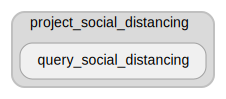

In [5]:
esp = esppy.ESP(hostname='http://localhost:9900')
esp_project = esp.create_project('project_social_distancing', 
                                 n_threads=8, 
                                 pubsub='manual')
esp_project.add_continuous_query('query_social_distancing')
esp_project

### Add an Window to receive the camera image

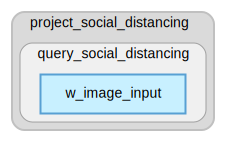

In [6]:
q1_vid_capture = esp.SourceWindow(schema=('id*:int64', 'image:blob'),
                                  index_type='empty', 
                                  insert_only=True,
                                  name='w_image_input')
esp_project.add_window(q1_vid_capture, contquery='query_social_distancing')
esp_project

### Add an window to resize the image to fit the Tiny YOLOv2 model

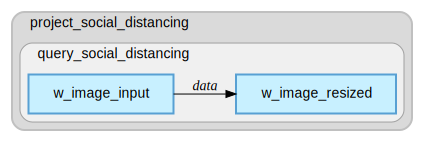

In [7]:
q1_resize = esp.CalculateWindow(schema=('id*:int64', 'image:blob', 'image_resized:blob'),
                                algorithm='ImageProcessing', 
                                name='w_image_resized', 
                                function='resize',
                                height=model_input_h, 
                                width=model_input_w, 
                                input_map=dict(imageInput='image'), 
                                output_map=dict(imageOutput='image_resized'))
esp_project.add_window(q1_resize, 'query_social_distancing')
q1_vid_capture.add_target(q1_resize, role='data')
esp_project

### Add two windows to load and deploy the model

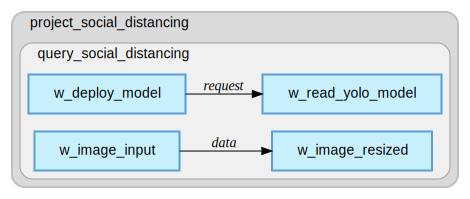

In [8]:
# Window: Model Reader
q1_model_reader = esp.ModelReaderWindow(name='w_read_yolo_model')
esp_project.add_window(q1_model_reader, contquery='query_social_distancing')

# Window: Model Request
q1_model_request = esp.SourceWindow(schema=('req_id*:int64', 'req_key:string', 'req_val:string'),
                                    index_type='empty', 
                                    insert_only=True,
                                    name='w_deploy_model')
esp_project.add_window(q1_model_request, contquery='query_social_distancing')
q1_model_request.add_target(q1_model_reader, role='request')
esp_project

### Add a window to use the model to score the images from the camera

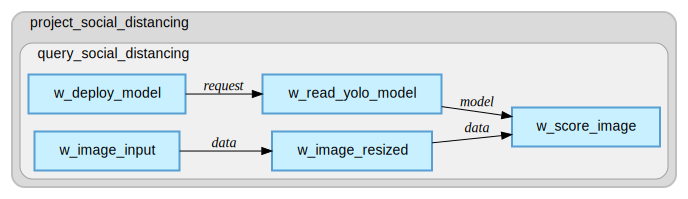

In [9]:
def score_window_fields(number_objects):
    _field = "id*:int64,image:blob,image_resized:blob,_nObjects_:double,"
    for obj in range(0,number_objects):
        _field += "_Object" + str(obj) + "_:string,"
        _field += "_P_Object" + str(obj) + "_:double,"
        _field += "_Object" + str(obj) + "_x:double,"
        _field += "_Object" + str(obj) + "_y:double,"
        _field += "_Object" + str(obj) + "_width:double,"
        _field += "_Object" + str(obj) + "_height:double,"
    return _field[:-1]
q1_model_score = esp.ScoreWindow(schema=score_window_fields(max_number_objects),
                                 name='w_score_image')
q1_model_score.add_offline_model(model_type='astore', 
                                 input_map=dict(_image_='image_resized'))
esp_project.add_window(q1_model_score, contquery='query_social_distancing')
q1_resize.add_target(q1_model_score, role='data')
q1_model_reader.add_target(q1_model_score, role='model')
esp_project

### Add a window to perform image transformation, distance calculation and crowd detection
* Window receives the detected objects and runs a Python code
* Initialize the window with user inputs
* Image shape, homography matrix, maximum distances to consider, minimum crowd size to consider

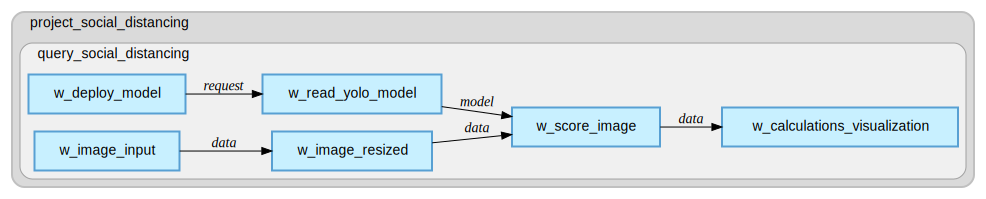

In [10]:
q1_wpython = esp.PythonHelper(schema=('id*:int64', 'scored_image:blob'), 
                              index_type='empty', 
                              produces_only_inserts=True, 
                              name='w_calculations_visualization',
                              pubsub=True)
q1_wpython.add_mas_info('module_1', 'func_social_distancing', 'w_score_image', code_file='./social_distancing.py', inits=dict(image_shape=(input_h,input_w,3), 
                                                                                                                              F=F.tolist(), 
                                                                                                                              max_distance_detection=max_distance_detection,
                                                                                                                              max_distance_detection_crowd=max_distance_detection_crowd,
                                                                                                                              min_crowd_size=min_crowd_size,
                                                                                                                              map_view=map_view))
esp_project.add_window(q1_wpython, contquery='query_social_distancing')
q1_model_score.add_target(q1_wpython, role='data')
esp_project

### Load the SAS Event Stream Processing project

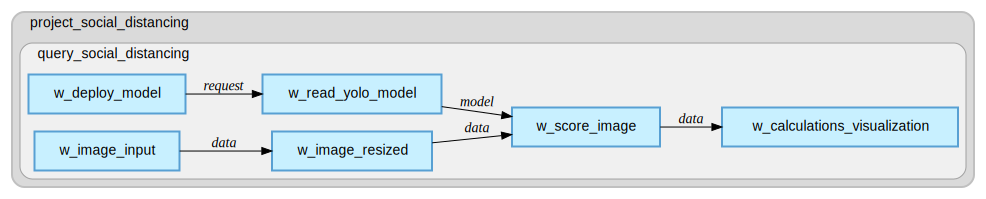

In [11]:
esp.load_project(esp_project)

### Create a Publisher to publish the model to the project

In [12]:
# Publisher: Send Model
q1_pub_model = q1_model_request.create_publisher(blocksize=1, rate=0, pause=0, dateformat='%Y%dT%H:%M:%S.%f', opcode='insert', format='csv')
q1_pub_model.send('i,n,1,"USEGPUESP","1"\n')
q1_pub_model.send('i,n,2,"ndevices","1"\n')
q1_pub_model.send('i,n,3,"action","load"\n')
q1_pub_model.send('i,n,4,"type","astore"\n')
q1_pub_model.send('i,n,5,"reference","/data/notebooks/SAS_DeepLearning/Social Distancing Demo/Tiny-Yolov2.astore"\n')
q1_pub_model.send('i,n,6,,\n')
q1_pub_model.close()

### Create a Publisher to publish camera images

In [13]:
# Publisher: Send Video
q1_pub_video = q1_vid_capture.create_publisher(blocksize=1, rate=0, pause=0, opcode='insert', format='csv')

### Publish Image frames into the SAS Event Stream Processing Project & Receive scored data
The class 'video_pub' extracts frames from a video and publishes them into SAS Event Stream Processing.<br>
The second class 'video_sub' subscribes to the Python-Window to receive the scored results.<br>
It will display the results in a window and - optionally - save the results to a video.

In [ ]:
# Class to publish videos to SAS Event Stream Processing
class video_pub():
    def __init__(self, publisher, video_file, video_quality=95):
        self.cap = cv2.VideoCapture(video_file)
        self.video_quality = video_quality
        self.pub = publisher
        threading.Thread(target=self.stream, daemon=True).start()
        print('Publisher started!')
        
    def stream(self):
        while True:
            ret, frame = self.cap.read()
            encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), self.video_quality]
            _, buffer = cv2.imencode('.jpg', frame, encode_param)
            encoded_string = base64.b64encode(buffer)
            strToSend = 'i, n, ' + str(int(time.time()*100)) + ',' + encoded_string.decode() + ',' + '\n'
            self.pub.send(strToSend)
            
# Class to subscribe to SAS Event Stream Processing to receive scored images - optionally save to video
class video_sub():
    def __init__(self, window, save_to_file=True, filename='', video_fps=25, video_size=(1920,1080)):
        self.ws = websocket.WebSocketApp(window.subscriber_url+"?format=json&mode=streaming&pagesize=1&schema=false",
                                 on_message = self.on_message,
                                 on_error = self.on_error,
                                 on_close = self.on_close)
        self.ws.on_open = self.on_open
        self.save_to_file = save_to_file
        if save_to_file == True:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
            self.out = cv2.VideoWriter(filename, fourcc, video_fps, video_size)
        threading.Thread(target=self.ws.run_forever, daemon=True).start()
        print('Subscriber Started!')
        return

    def on_message(self, message):
        try:
            data = json.loads(message)
            imageBufferBase64 = data['events'][0]['event']['scored_image']['scored_image']
            nparr = np.frombuffer(base64.b64decode(imageBufferBase64), dtype=np.uint8)
            frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            if self.save_to_file == True:
                self.out.write(frame)
            cv2.imshow('frame',frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
        except Exception as e:
            print(e)

    def on_error(self, error):
        print(error)

    def on_close(self):
        print("Websocket closed!")

    def on_open(self):
        print('Websocket open!')

publisher = video_pub(publisher=q1_pub_video,
                      video_file='/data/notebooks/SAS_DeepLearning/Social Distancing Demo/shopping_mall.mkv',
                      video_quality=95)
subscriber = video_sub(window=q1_wpython, 
                       save_to_file=False, 
                       filename='/data/notebooks/SAS_DeepLearning/Social Distancing Demo/shopping_mall_scored_wo_map2.avi', 
                       video_fps=25, 
                       video_size=(1920,1080)) #2855,1080